In [71]:
import re
import spacy
import pandas as pd
import networkx as nx
from tqdm import tqdm
from spacy import displacy
import matplotlib.pyplot as plt
from pyvis.network import Network
from utils import *

spacy.prefer_gpu()
tqdm.pandas()

TOP_MESSAGES_BY_TIMEFRAME = 1_000
MIN_FREQUENCY_RATIO_EDGES = 0.99

CHARS_TO_REMOVE = [
    "'s",
    "/",
    "\\",
    "/",
    "-",
    "'",
    "`s",
    "`"
]

NER = spacy.load("en_core_web_lg")
NER_LABELS = ['PERSON']

EMOJI_PATTERN = re.compile("["
                           u"\U0001F600-\U0001F64F" #emotions
                           u"\U0001F300-\U0001F5FF" #sumbols and pictographs
                           u"\U0001F680-\U0001F6FF" #transport and map symbols
                           u"\U0001F1E0-\U0001F1FF" #flags
                           u"\U00002702-\U000027B0"  
                           u"\U000024C2-\U0001F251" 

                           "]+",flags = re.UNICODE)

In [72]:
messages = pd.read_csv('../../../data/telegram/messages_scraped.csv')
messages['messageDateTime'] = messages['messageDate'].astype('datetime64[ns]')
messages['year_month'] = messages['messageDateTime'].dt.strftime('%Y_%m')
print('Cleaning Chat name (node to be):')
messages['chat'] = messages.chat.progress_apply(lambda x: x.replace('https://t.me/', ''))
print('Removing Emojis:')
messages.messageText = messages.messageText.progress_apply(lambda x: EMOJI_PATTERN.sub(r'', x))
print('Removing Special Chars:')
for sc in CHARS_TO_REMOVE:
    messages.messageText = messages.messageText.progress_apply(lambda x: x.replace(sc, ' '))
print('Removing Stop Words:')
messages.messageText = messages.messageText.progress_apply(lambda x: remove_stopwords(x, STOPWORDS))

messages = compute_popularity(messages)

/var/folders/fb/v6scng3j5lbcmnb3mjn82zhr0000gn/T/ipykernel_46920/3948642204.py:1: DtypeWarning: Columns (22,25,26,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  messages = pd.read_csv('../../../data/telegram/messages_scraped.csv')


Cleaning Chat name (node to be):


100%|██████████| 152345/152345 [00:00<00:00, 1345472.94it/s]


Removing Emojis:


100%|██████████| 152345/152345 [00:01<00:00, 138609.96it/s]


Removing Special Chars:


100%|██████████| 152345/152345 [00:00<00:00, 1714612.59it/s]


Removing Stop Words:


100%|██████████| 152345/152345 [00:31<00:00, 4809.10it/s]


In [73]:
# chat = messages[messages.chat == 'financialtimes']
chat = messages

In [74]:
docs = []

for time_frame in tqdm(list(chat.messageDate.unique())):
    top_daily_messages = list(chat[chat.messageDate == time_frame].sort_values('popularity_score',ascending = False).head(TOP_MESSAGES_BY_TIMEFRAME).messageText.values)
    docs.append({
        'messages': top_daily_messages,
        'document': '\n'.join(top_daily_messages),
        'frame': time_frame
    })

100%|██████████| 1587/1587 [00:10<00:00, 152.82it/s]


In [75]:
from itertools import combinations
edge_list = []

for doc in tqdm(docs):
    entities = ner_message(doc['document'], NER, NER_LABELS)
    for sentence_entities in entities:
        if len(sentence_entities)>1:
            edge_list.extend(combinations(sentence_entities, 2))

100%|██████████| 1587/1587 [09:33<00:00,  2.76it/s]


In [76]:
print(len(edge_list))

49201


In [116]:
import requests
edges = pd.DataFrame(edge_list, columns=['source', 'target'])

count_series = edges.groupby(['source', 'target']).size()
edges = count_series.to_frame(name = 'value').reset_index()
edges.source = edges.source.progress_apply(lambda x: x.strip())
edges.target = edges.target.progress_apply(lambda x: x.strip())
edges = edges[(edges['source'].str.len() > 3) & (edges['target'].str.len() > 3)] # Only consider entities with a str length higher than 1

all_entities = list(set([*edges.source.values, *edges.target.values]))
matches = {}
for my_ent in tqdm(all_entities):
    url = "https://www.wikidata.org/w/api.php?action=wbsearchentities&search={entity}&language=en&format=json"
    res = requests.get(url.format(entity=my_ent))
    obj = json.loads(res.text)
    if len(obj['search']) > 0:
        top_match = obj['search'][0]['display']['label']['value']
        matches['my_ent'] = top_match

edges['source_wd'] = edges.source.progress_apply(lambda x: matches[x])
edges['target_wd'] = edges.target.progress_apply(lambda x: matches[x])

# edges = filter_graph(edges, ['Vladimir Putin'], 2) # Uncomment to get subgraph for a specified list of entities
filtered_edges = edges[edges.value > edges.value.quantile(MIN_FREQUENCY_RATIO_EDGES)]
filtered_edges

 30%|██▉       | 4971/16788 [22:45<54:05,  3.64it/s]  


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [84]:
from pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt

G = nx.from_pandas_edgelist(
    filtered_edges,
    source='source',
    target='target',
    edge_attr='value',
    create_using=nx.Graph()
)

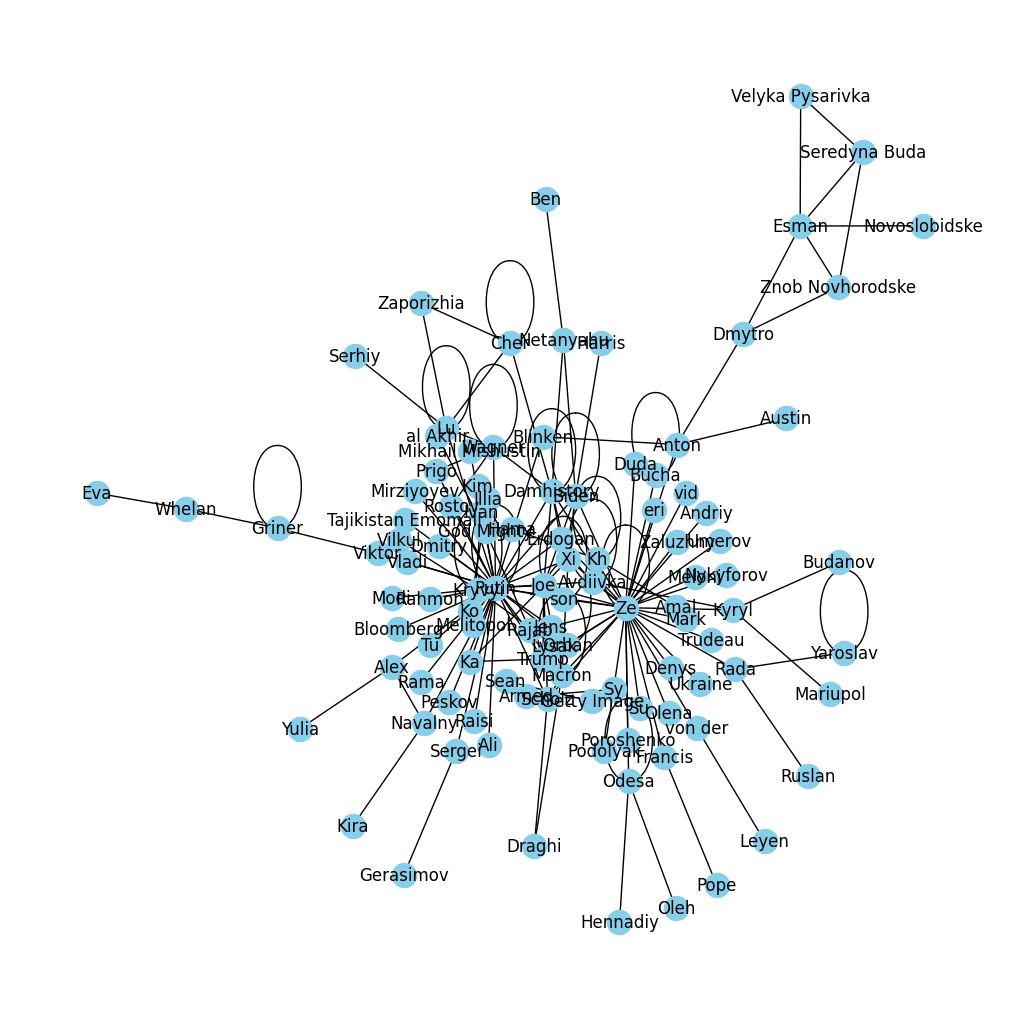

In [85]:
import community as community_louvain

communities = community_louvain.best_partition(G)
nx.set_node_attributes(G, communities, 'group')

degree_nodes = dict(G.degree)
nx.set_node_attributes(G, degree_nodes, 'size')

plt.figure(figsize=(10, 10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', arrowsize=10, arrows=True, edge_cmap=plt.cm.Blues)

net = Network(notebook=True, width='100wh', height='75vh', bgcolor='#222222', font_color='white')
net.from_nx(G)

net.toggle_physics(False)
net.show_buttons(filter_=['physics'])
net.save_graph(f'all_daily_top_{TOP_MESSAGES_BY_TIMEFRAME}_value_gt_{MIN_FREQUENCY_RATIO_EDGES*100}_w_wikidata.html')